In [1]:
# Execute this cell first to load custom css
from IPython.core.display import HTML
HTML(filename="./assets/theme.html")

![MLU_Logo](./assets/MLU_Logo.png)

# Quick Start Workshop to Modern Forecasting

## <a name="0">NOTEBOOK 3. DeepAR Forecasting Algorithm in Amazon SageMaker</a>


### Forecasting with DeepAR on SageMaker

This notebook shows how to prepare a dataset of time series for training DeepAR on SageMaker and how to use the trained model for inference. 

Amazon SageMaker trains the DeepAR model by randomly sampling training examples from each target time series in the training dataset. Each training example consists of a pair of adjacent context and prediction windows with fixed predefined lengths.

For this example we will use the data set [M4-hourly](https://en.wikipedia.org/wiki/Makridakis_Competitions#Fourth_competition,_started_on_January_1,_2018,_ended_on_May_31,_2018), a subset of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) data set that consists of a 414 time series sampled at 1h intervals. 

### Table of Contents

1. <a href="#1">Prepare Data</a> 
2. <a href="#2">Configure SageMaker to Use DeepAR and Train</a> 
3. <a href="#3">Create Endpoint and Predictor</a>
4. <a href="#4">Delete Endpoints</a>

We install GluonTS to have access to its datasets for this demo. Note that when training on your own dataset, you would not need to install GluonTS.

In [2]:
!pip install --upgrade --quiet gluonts

In [3]:
# Import libraries
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
import s3fs

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [4]:
params = {
    "legend.fontsize": "x-large",
    "figure.titlesize": "xx-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "figure.figsize": (14, 5),
}
plt.rcParams.update(params)

## <a name="1">1. Prepare Data</a>

(<a href="#0">Go to top</a>)


The [M4-hourly](https://en.wikipedia.org/wiki/Makridakis_Competitions#Fourth_competition,_started_on_January_1,_2018,_ended_on_May_31,_2018) dataset is a subset of the data published for the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). The full dataset for the competition consisted of 100,000 time series sampled at different frequencies. The M4-hourly set contains 414 time series data sampled at 1h intervals. 

We will download the data using GluonTS.

In [5]:
dataset = get_dataset("m4_hourly", regenerate=False)

Let's inspect some of the time series of this data set:

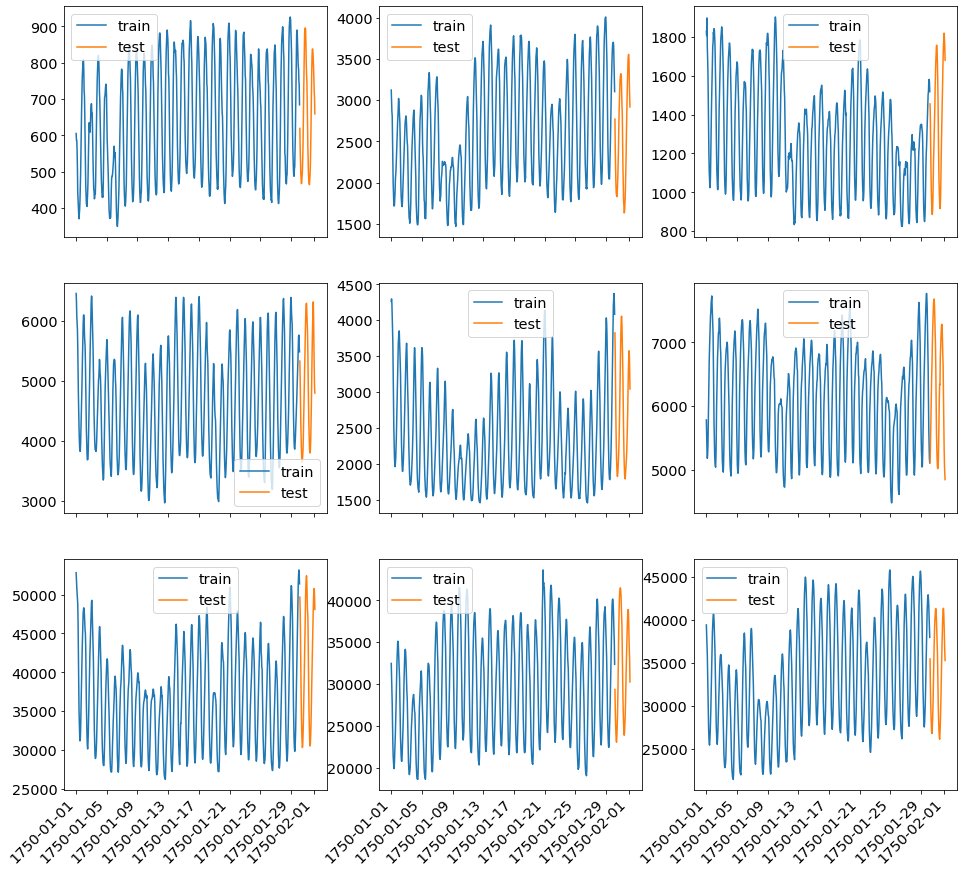

In [6]:
num_plots = 9
axes = list(np.ndindex(3, 3))

fig, axes = plt.subplots(3, 3, sharex=True, figsize=(16, 16))

for i, (train, test, ax) in enumerate(zip(dataset.train, dataset.test, axes.flatten())):

    tra = to_pandas(train)
    tra.index = tra.index.to_timestamp()
    te = to_pandas(test)
    te.index = te.index.to_timestamp()
    
    len_train = len(tra)
    ax.plot(te[:len_train], label="train")
    ax.plot(te[len_train:], label="test")
    fig.autofmt_xdate(rotation=45)
    ax.legend()
    if i == num_plots:
        break

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case, each time series just consists of a start time stamp (`start`) and a list of values (`target`). For more complex cases, DeepAR also supports the fields `dynamic_feat` for time series features and `cat` for categorical features, which we will use later.

Fortunately, the data downloaded from GluonTS is already in the format needed by SageMaker when it trains the DeepAR algorithm. 

In [7]:
# The GluonTS m4-hourly dataset is already in the format required by DeepAR in SageMaker
train.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'item_id'])

Since we have the data files locally, let us upload them to S3 where DeepAR can access them. The following cell sets up the S3 path where the m4-hourly data files will be uploaded to. 

In [8]:
# Change to your desired S3 prefix
prefix = "sagemaker/deepar-sagemaker"

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

This cell uploads the files from the original location where GluonTS saved them to our desired S3 location so that SageMaker is able to find them when training DeepAR.

In [9]:
encoding = "utf-8"
FILE_TRAIN = "/home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json.gz"
FILE_TEST = "/home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json.gz"

s3 = boto3.client("s3")
s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/train.json.gz")
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/test.json.gz")

## <a name="2">2. Configure SageMaker to Use DeepAR and Train</a>

(<a href="#0">Go to top</a>)

We configure the container image to be used for the region that we are running in.

In [10]:
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", region)

Next we define the estimator that will launch the training job. We can specify the type of instance where the training will take place.

In [11]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="deepar-sagemaker",
    output_path=f"s3://{s3_output_path}",
)

Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate, number of layers, number of cells per layer). Refer to the documentation for a full description of the [available parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

For `context_length`, the number of time-points that the model gets to see before making the prediction, this value  should be about the same as the `prediction_length`, but it can be modified and made larger as well.

In [12]:
hyperparameters = {
    "time_freq": "H",
    "context_length": str(dataset.metadata.prediction_length),
    "prediction_length": str(dataset.metadata.prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "50",
    "mini_batch_size": "32",
    "learning_rate": "1e-3",
    "early_stopping_patience": "10",
}

estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the test data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note**: the next cell will take a few minutes to complete, depending on data size, model complexity, and training options.

In [13]:
data_channels = {
    "train": f"s3://{s3_data_path}/train/",
    "test": f"s3://{s3_data_path}/test/",
}

estimator.fit(inputs=data_channels)

2022-10-05 18:15:44 Starting - Starting the training job...
2022-10-05 18:16:07 Starting - Preparing the instances for trainingProfilerReport-1664993744: InProgress
......
2022-10-05 18:17:12 Downloading - Downloading input data...
2022-10-05 18:17:32 Training - Downloading the training image.........
2022-10-05 18:19:08 Training - Training image download completed. Training in progress.Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[10/05/2022 18:19:06 INFO 140306814555968] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input

## <a name="3">3. Create Endpoint and Predictor</a>

(<a href="#0">Go to top</a>)

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class `DeepARPredictor`. This class extends the `Predictor` class. Implementing encode and decode functions helps us make requests using `pandas.Series` objects rather than raw JSON strings.

In [14]:
from sagemaker.serializers import IdentitySerializer

In [15]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.025", "0.1", "0.5", "0.9", "0.975"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(
            ts, cat, dynamic_feat, num_samples, return_samples, quantiles
        )
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(
            res, ts.index.freq, prediction_time, return_samples
        )

    def __encode_request(
        self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles
    ):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"]
            if return_samples
            else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {
                "sample_" + str(i): s for i, s in enumerate(predictions["samples"])
            }
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.
This cell takes some minutes to run.

In [16]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

------!

Let us look at the forecasts that the trained model makes for the first few dataseries of our dataset. We will plot predicted median and confidence intervals.

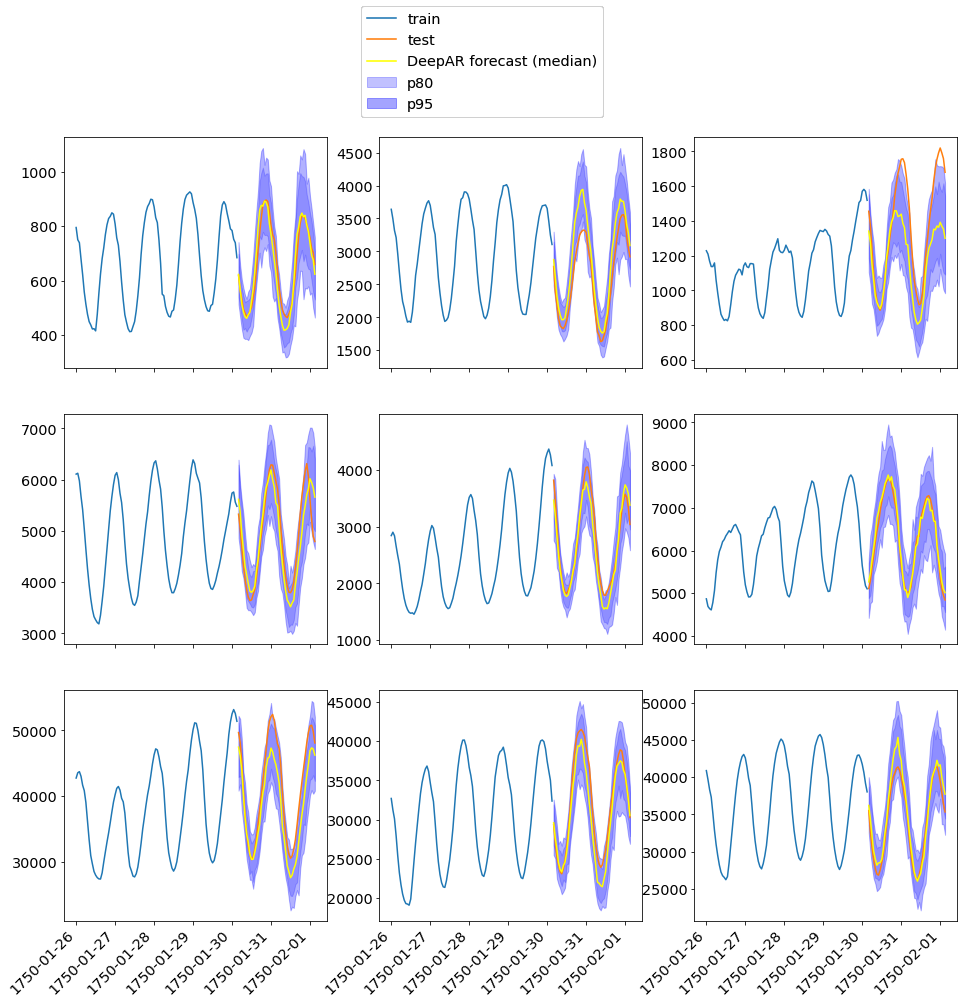

In [17]:
num_plots = 9
axes = list(np.ndindex(3, 3))

fig, axes = plt.subplots(3, 3, sharex=True, figsize=(16, 16))

for i, (train, test, ax) in enumerate(zip(dataset.train, dataset.test, axes.flatten())):
    
    tra = to_pandas(train)
    tra.index = tra.index.to_timestamp()
    te = to_pandas(test)
    te.index = te.index.to_timestamp()

    len_train = len(tra)
    ax.plot(te[len_train - 100 : len_train], label="train")
    ax.plot(te[len_train:], label="test")

    # Use our deployed model to make predictions
    forecast = predictor.predict(ts=tra)

    ax.plot(forecast["0.5"], color="yellow", label="DeepAR forecast (median)")
    ax.fill_between(
        forecast.index,
        forecast["0.1"],
        forecast["0.9"],
        color="b",
        alpha=0.2,
        label="p80",
    )
    ax.fill_between(
        forecast.index,
        forecast["0.025"],
        forecast["0.975"],
        color="b",
        alpha=0.3,
        label="p95",
    )

    fig.autofmt_xdate(rotation=45)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center")
    if i == num_plots:
        break

Let us inspect the prediction for one of the time series in the dataset.

In [18]:
prediction = predictor.predict(ts=tra)
prediction.head()

,0.025,0.1,0.5,0.9,0.975
1750-01-30 04:00:00,32509.859375,33532.089844,36186.781250,38732.406250,39979.878906
1750-01-30 05:00:00,29903.689453,32206.820312,34366.742188,36621.667969,38418.171875
1750-01-30 06:00:00,28050.636719,29669.277344,32175.818359,35075.062500,35585.695312
1750-01-30 07:00:00,26399.398438,27750.138672,30094.505859,32735.617188,33807.316406
1750-01-30 08:00:00,25716.291016,26451.181641,29039.412109,31161.140625,32387.652344


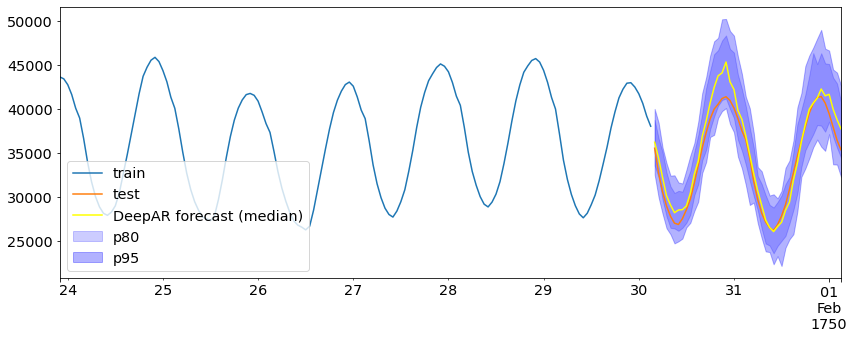

In [19]:
len_train = len(tra)
te[len_train - 150 : len_train].plot(label="train")
te[len_train:].plot(label="test")

prediction["0.5"].plot(color="yellow", label="DeepAR forecast (median)")
plt.fill_between(
    prediction.index,
    prediction["0.1"],
    prediction["0.9"],
    color="b",
    alpha=0.2,
    label="p80",
)
plt.fill_between(
    prediction.index,
    prediction["0.025"],
    prediction["0.975"],
    color="b",
    alpha=0.3,
    label="p95",
)
plt.legend(loc="lower left")
plt.show()

## <a name="4">4. Delete Endpoints</a>

(<a href="#0">Go to top</a>)

Amazon SageMaker stores the trained model in the cloud and provisions the requested infrastructure for its deployment. Upon finishing development and experimentation, one should remember to delete the model and associated endpoints to avoid incurring in unforeseen costs. 

In [20]:
predictor.delete_model()
predictor.delete_endpoint()

## **Conclusion**

In this notebook we've learned how to leverage SageMaker capabilities to train ML models in the cloud. We've used DeepAR for forecasting time series data. This is one of the built-in models available in Amazon SageMaker.  

DeepAR is capable of handling multiple time series, creating a single global model. It even has the potential to solve a cold start problem i.e. to generate forecasts for new time series that do not have historical observations but are similar to the ones it has been trained on.

Using DeepAR in SageMaker we can focus on experimenting with our time series to get the best possible results, without worrying about the internal infrastructure. We can get the job done very quickly as there is no need to write any training code. All we need to do is prepare the data and do the necessary tunings to refine the model if needed.